# pg_server___cron_jobs
Provides information about cron jobs running in the DB. 

Cells: 
- Configure: Connect to a specfic DB
- Current size of each table: in KB, dead rows, bloat, data size, all indexes size,  


PreReq: 
- ```pip install cron-descriptor```

In [9]:
import sys
print(sys.path)

from cron_descriptor import get_description, ExpressionDescriptor

['/Users/itaybraun/Documents/GitHub/db-observability-toolkit/Notebooks/Notebooks_Drafts', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/itaybraun/Library/Python/3.10/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages']


In [10]:
import sqlalchemy
import pandas as pd
import configparser
import matplotlib.pyplot as plt 
from IPython.display import HTML


# Read from the Config file
config = configparser.ConfigParser() 
# As long as the notebook in the "Notebooks_Drafts" folder, use r'../../ipynb.cfg'
config.read_file(open(r'../../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 
engine = sqlalchemy.create_engine(con_str)

try:
    connection = engine.connect()
    print ("Opened Connection")
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)


Opened Connection


## Configuration
View the configurations related to the cron jobs in the current DB

In [11]:
qry_cron_configuration = """
-- Cron Jobs
SELECT name, setting, short_desc, extra_desc, source, min_val, max_val
FROM pg_settings 
WHERE name like '%%cron%%' 
"""
df = pd.read_sql_query(qry_cron_configuration, connection)
df


,name,setting,short_desc,extra_desc,source,min_val,max_val
0,cron.database_name,airbases,Database in which pg_cron metadata is kept.,None,configuration file,None,None
1,cron.enable_superuser_jobs,on,Allow jobs to be scheduled as superuser,None,default,None,None
2,cron.host,localhost,Hostname to connect to postgres.,This setting has no effect when background wor...,default,None,None
3,cron.log_min_messages,warning,log_min_messages for the launcher bgworker.,None,configuration file,None,None
4,cron.log_run,on,Log all jobs runs into the job_run_details table,None,configuration file,None,None
5,cron.log_statement,on,Log all cron statements prior to execution.,None,configuration file,None,None
6,cron.max_running_jobs,1,Maximum number of jobs that can run concurrently.,None,configuration file,0,7
7,cron.use_background_workers,on,Use background workers instead of client sessi...,None,configuration file,None,None


## Number of jobs and size of the history table

In [12]:
qry_jobs_tables_stats = """ 
SELECT 
	min(j.count_jobs) as count_jobs, 
	count(jobid) as count_history_rows, 
  min(start_time) as oldest_job_history,
  now() -  min(start_time) as oldest_job_history_str,
  max(start_time) as newest_job_history
FROM cron.job_run_details AS rd
cross join ( SELECT count(*) as count_jobs
from cron.job) as j """ 
df = pd.read_sql_query(qry_jobs_tables_stats, connection)
df 



,count_jobs,count_history_rows,oldest_job_history,oldest_job_history_str,newest_job_history
0,6,123523,2023-05-21 15:30:00.068394+00:00,107 days 05:35:16.302263,2023-09-05 21:05:02.371539+00:00


## Analyze the size of the job_run_details
If the value is higher than 10,000 (feel free to select any other value) then you should run a daily job to delete data older than 7 days (or any other history length)

TODO: write here the command: 

In [13]:
# Find the value of the 'count_history_rows' column
value = df['count_history_rows'].iloc[0]

# Check if the value is higher than 10000 and display it in red if true
if value > 10000:
    message = f"<font color='pink'>The value of count_history_rows ({value}) is higher than 10000</font>"
else:
    message = f"The value of count_history_rows ({value}) is within the allowed limit."

# Display the message with HTML formatting
display(HTML(message))

## The Details of the Job
For each job show its: 
- jobid and name
- is active

In [20]:
qry_jobs_details = """ 

-- Jobs' details
SELECT 
	jobid,  
  schedule, 
  command, 
  length(command),
  nodename, 
  nodeport, 
  database, 
  username, 
  active
  jobname
FROM cron.job; """ 
print(get_description("* 2 3 * *"))

df = pd.read_sql_query(qry_jobs_details, connection)
df["schedule_text"] = df["schedule"].apply(get_description)
df


Every minute, between 02:00 AM and 02:59 AM, on day 3 of the month


,jobid,schedule,command,length,nodename,nodeport,database,username,jobname,schedule_text
0,1,*/10 * * * *,select *\nfrom (select * from postgres_air.boa...,170,localhost,5432,airbases,postgres,True,Every 10 minutes
1,3,*/1 * * * *,\n -- Your SQL query goes here\n ...,738,localhost,5432,airbases,postgres,True,Every minute
2,4,*/1 * * * *,\n INSERT INTO metis.pg_stat_tables_act...,854,localhost,5432,airbases,postgres,True,Every minute
3,5,0 1 * * *,\n SELECT delete_old_data_periodically()\n,46,localhost,5432,airbases,postgres,True,At 01:00 AM
4,6,*/1 * * * *,"INSERT INTO metis.queries (query_id, query_tex...",462,localhost,5432,airbases,postgres,True,Every minute
5,7,*/5 * * * *,\n INSERT INTO metis.query_stats_snapshots ...,516,localhost,5432,airbases,postgres,True,Every 5 minutes


## Job Execution Statistics
Some statistics about the jobs run in the last 7 days (Configurable): 
- Number of times the job run
- How many times it finished succesfully or with a failure. 
- Avg duration. 
- First time and last time it run in the monitored duration. 

In [ ]:
qry_job_history_stats = """ 
--
SELECT 
	j.jobid, 
  j.jobname,
	count(runid) as count_job_runs, 
  SUM (case rd.status
  	WHEN 'succeeded' then 1 ELSE 0 END) AS count_success, 
  SUM (case rd.status
  	WHEN 'failed' then 1 ELSE 0 END) AS count_failure, 
  --count(runid) / SUM ((case rd.status WHEN 'failed' then 1 ELSE 0 END)::numeric) as success_pct,  
  min(start_time) AS first_run, 
  max(start_time) AS last_run,
 	SUM( 
    	(EXTRACT(EPOCH FROM end_time - start_time) * 1000)::bigint 
    ) AS total_job_duration_ms, 
  SUM( 
    	(EXTRACT(EPOCH FROM end_time - start_time) * 1000)::bigint 
    )  / 
  SUM (case rd.status WHEN 'succeeded' then 1 ELSE 0 END) AS avg_duration_succesful_runs
FROM 
	cron.job_run_details AS rd
JOIN 
	cron.job AS j 
  	ON rd.jobid = j.jobid
WHERE j.active = true
GROUP BY 
	j.jobid, 
  j.jobname

"""
df = pd.read_sql_query(qry_job_history_stats, connection)
df 

,jobid,jobname,count_job_runs,count_success,count_failure,first_run,last_run,total_job_duration_ms,avg_duration_succesful_runs
0,1,pmc data reliability,8890,8889,1,2023-05-21 15:30:00.068394+00:00,2023-09-05 20:30:00.118706+00:00,3280967.0,369.104174
1,3,my_cron_job,39374,39362,12,2023-08-09 12:23:00.036840+00:00,2023-09-05 20:36:00.094432+00:00,9682712.0,245.991362
2,4,pg_stat_tables_activity_snapshots,34904,34893,11,2023-08-12 14:53:00.010841+00:00,2023-09-05 20:36:00.085173+00:00,11839064.0,339.296249
3,5,pg_monitor__delete_old_data,24,24,0,2023-08-13 01:00:00.062161+00:00,2023-09-05 01:00:01.120887+00:00,71629.0,2984.541667
4,6,pg_stat_statements_queries,33538,33515,23,2023-08-13 13:39:00.006730+00:00,2023-09-05 20:36:00.025178+00:00,2304282.0,68.753752
5,7,pg_stat_statements_queries_measures,6695,6693,2,2023-08-13 14:45:02.118176+00:00,2023-09-05 20:35:00.097408+00:00,1467343.0,219.235470


## Run Details of a specific Job 

In [ ]:
qry_job_run_details = """ 
-- Last 100 runs
SELECT * 
FROM cron.job_run_details 
WHERE jobid = 3
ORDER BY start_time desc
LIMIT 100;   """ 

df = pd.read_sql_query(qry_job_run_details, connection)
df 

,jobid,runid,job_pid,database,username,command,status,return_message,start_time,end_time
0,3,5131,NaN,airbases,postgres,\n -- Your SQL query goes here\n ...,failed,could not start background process; more detai...,NaT,NaT
1,3,63903,NaN,airbases,postgres,\n -- Your SQL query goes here\n ...,failed,could not start background process; more detai...,NaT,NaT
2,3,63906,NaN,airbases,postgres,\n -- Your SQL query goes here\n ...,failed,could not start background process; more detai...,NaT,NaT
3,3,65295,NaN,airbases,postgres,\n -- Your SQL query goes here\n ...,failed,could not start background process; more detai...,NaT,NaT
4,3,64315,NaN,airbases,postgres,\n -- Your SQL query goes here\n ...,failed,could not start background process; more detai...,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
95,3,123153,3545.0,airbases,postgres,\n -- Your SQL query goes here\n ...,succeeded,INSERT 0 1,2023-09-05 19:13:00.088169+00:00,2023-09-05 19:13:00.093132+00:00
96,3,123150,3436.0,airbases,postgres,\n -- Your SQL query goes here\n ...,succeeded,INSERT 0 1,2023-09-05 19:12:00.093097+00:00,2023-09-05 19:12:00.098530+00:00
97,3,123147,3328.0,airbases,postgres,\n -- Your SQL query goes here\n ...,succeeded,INSERT 0 1,2023-09-05 19:11:00.087964+00:00,2023-09-05 19:11:00.093244+00:00
98,3,123143,3213.0,airbases,postgres,\n -- Your SQL query goes here\n ...,succeeded,INSERT 0 1,2023-09-05 19:10:00.268865+00:00,2023-09-05 19:10:00.273953+00:00


## Testing Mini series
Aug 21 - test failed. Can't show it all in one object. 

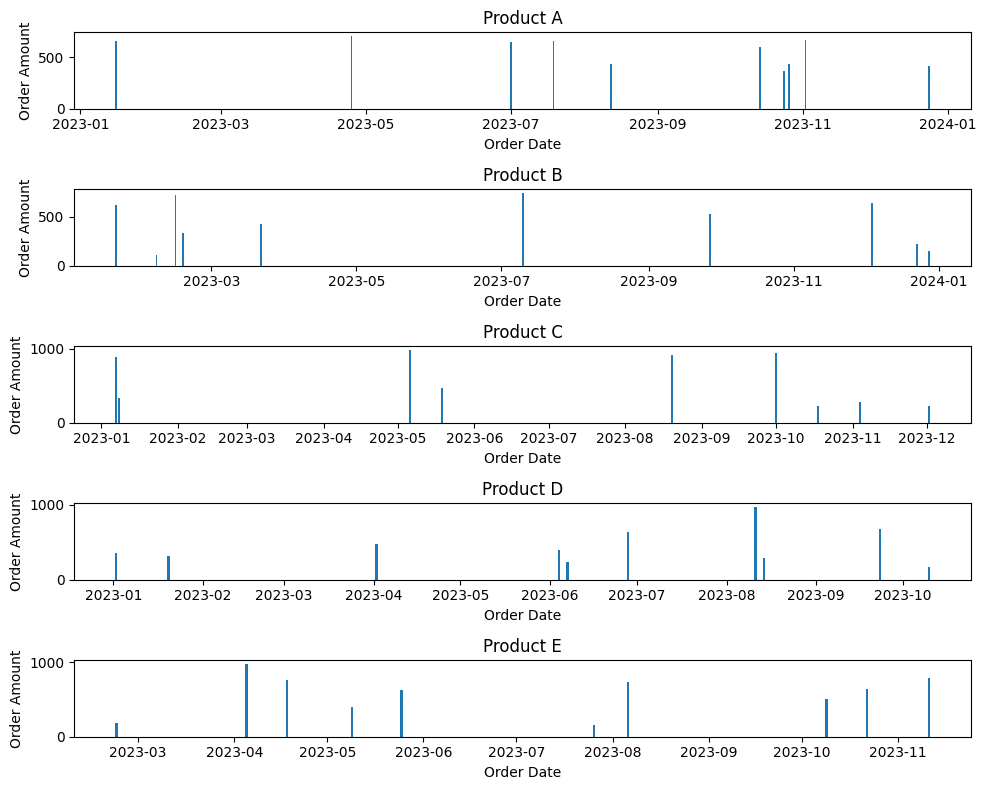

In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create empty DataFrame
data = {
    'product_name': [],
    'orderdate': [],
    'order_amount': []
}

# List of products
products = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']

# Generate 10 random dates for each product
for product in products:
    for _ in range(10):
        random_date = datetime(2023, random.randint(1, 12), random.randint(1, 28))
        data['product_name'].append(product)
        data['orderdate'].append(random_date)
        data['order_amount'].append(random.randint(100, 1000))

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
# print(df)
# Create subplots for each product
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(5, 1, figure=fig)

for i, product in enumerate(products):
    ax = fig.add_subplot(gs[i, 0])
    product_data = df[df['product_name'] == product]
    ax.bar(product_data['orderdate'], product_data['order_amount'])
    ax.set_title(product)
    ax.set_xlabel('Order Date')
    ax.set_ylabel('Order Amount')

plt.tight_layout()
plt.show()